# **Importing The Dataset and The Libraries**

In [ ]:
import kagglehub
path = kagglehub.dataset_download("gti-upm/leapgestrecog")
print("Path to dataset files:", path)

100%|██████████| 2.13G/2.13G [00:22<00:00, 101MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gti-upm/leapgestrecog/versions/1


In [ ]:
!pip install kagglehub --quiet
import kagglehub
import os
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Downloading The Dataset**

In [ ]:
path = kagglehub.dataset_download("gti-upm/leapgestrecog")
print("Raw download path:", path)

Raw download path: /root/.cache/kagglehub/datasets/gti-upm/leapgestrecog/versions/1


In [ ]:
root_dir = Path(path) / "leapGestRecog"
if not root_dir.is_dir():
    root_dir = Path(path)

print("Using root dir:", root_dir)

Using root dir: /root/.cache/kagglehub/datasets/gti-upm/leapgestrecog/versions/1/leapGestRecog


In [ ]:
subjects = sorted([d for d in os.listdir(root_dir) if not d.startswith('.')])
print("Found subject folders:", subjects)

Found subject folders: ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09']


**Build The Dataset (images + labels)**

In [ ]:
IMG_SIZE = 128

x_data = []
y_labels = []
gesture_names = []
subject_ids = []

label_lookup = {}   # gesture_name -> int
reverse_lookup = {} # int -> gesture_name
label_count = 0

In [ ]:
for subject in sorted(os.listdir(root_dir)):
    if subject.startswith('.'):
        continue
    subject_path = root_dir / subject
    if not subject_path.is_dir():
        continue

    for gesture in sorted(os.listdir(subject_path)):
        if gesture.startswith('.'):
            continue
        gesture_path = subject_path / gesture
        if not gesture_path.is_dir():
            continue

        if gesture not in label_lookup:
            label_lookup[gesture] = label_count
            reverse_lookup[label_count] = gesture
            label_count += 1

        label_idx = label_lookup[gesture]

        for img_name in os.listdir(gesture_path):
            if img_name.startswith('.'):
                continue
            img_path = gesture_path / img_name

            try:
                img = Image.open(img_path).convert("L")
                img = img.resize((IMG_SIZE, IMG_SIZE))
                img_arr = np.array(img)

                x_data.append(img_arr)
                y_labels.append(label_idx)
                gesture_names.append(gesture)
                subject_ids.append(subject)
            except Exception as e:
                print("Error reading", img_path, ":", e)

In [ ]:
x_data = np.array(x_data)
y_labels = np.array(y_labels)

print("x_data shape:", x_data.shape)
print("Number of samples:", len(x_data))
print("Number of classes:", len(label_lookup))
print("Classes mapping:", label_lookup)

x_data shape: (20000, 128, 128)
Number of samples: 20000
Number of classes: 10
Classes mapping: {'01_palm': 0, '02_l': 1, '03_fist': 2, '04_fist_moved': 3, '05_thumb': 4, '06_index': 5, '07_ok': 6, '08_palm_moved': 7, '09_c': 8, '10_down': 9}


In [ ]:
df = pd.DataFrame({
    "subject": subject_ids,
    "gesture": gesture_names,
    "label": y_labels
})

print("DataFrame head:")
display(df.head())

DataFrame head:


,subject,gesture,label
0,00,01_palm,0
1,00,01_palm,0
2,00,01_palm,0
3,00,01_palm,0
4,00,01_palm,0


# **Simple Data Visualization**

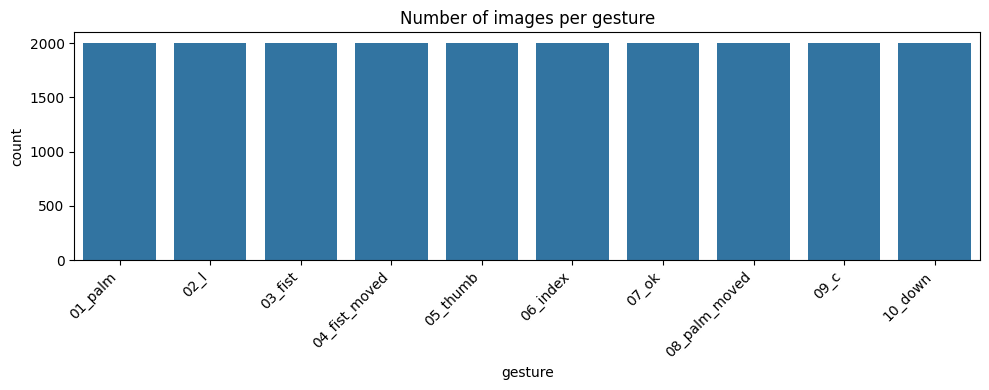

In [ ]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x="gesture", order=sorted(df["gesture"].unique()))
plt.xticks(rotation=45, ha="right")
plt.title("Number of images per gesture")
plt.tight_layout()
plt.show()

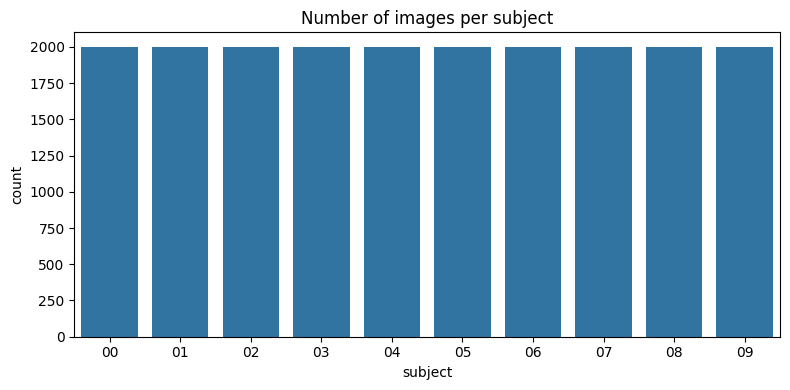

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x="subject", order=sorted(df["subject"].unique()))
plt.title("Number of images per subject")
plt.tight_layout()
plt.show()

In [ ]:
def show_random_samples(images, labels_int, n=16):
    n = min(n, len(images))
    indices = np.random.choice(len(images), size=n, replace=False)
    n_cols = 4
    n_rows = int(np.ceil(n / n_cols))

    plt.figure(figsize=(12, 3 * n_rows))
    for i, idx in enumerate(indices):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[idx], cmap="gray")
        plt.axis("off")
        plt.title(reverse_lookup[labels_int[idx]], fontsize=10)
    plt.suptitle("Random samples from dataset", fontsize=16)
    plt.tight_layout()
    plt.show()

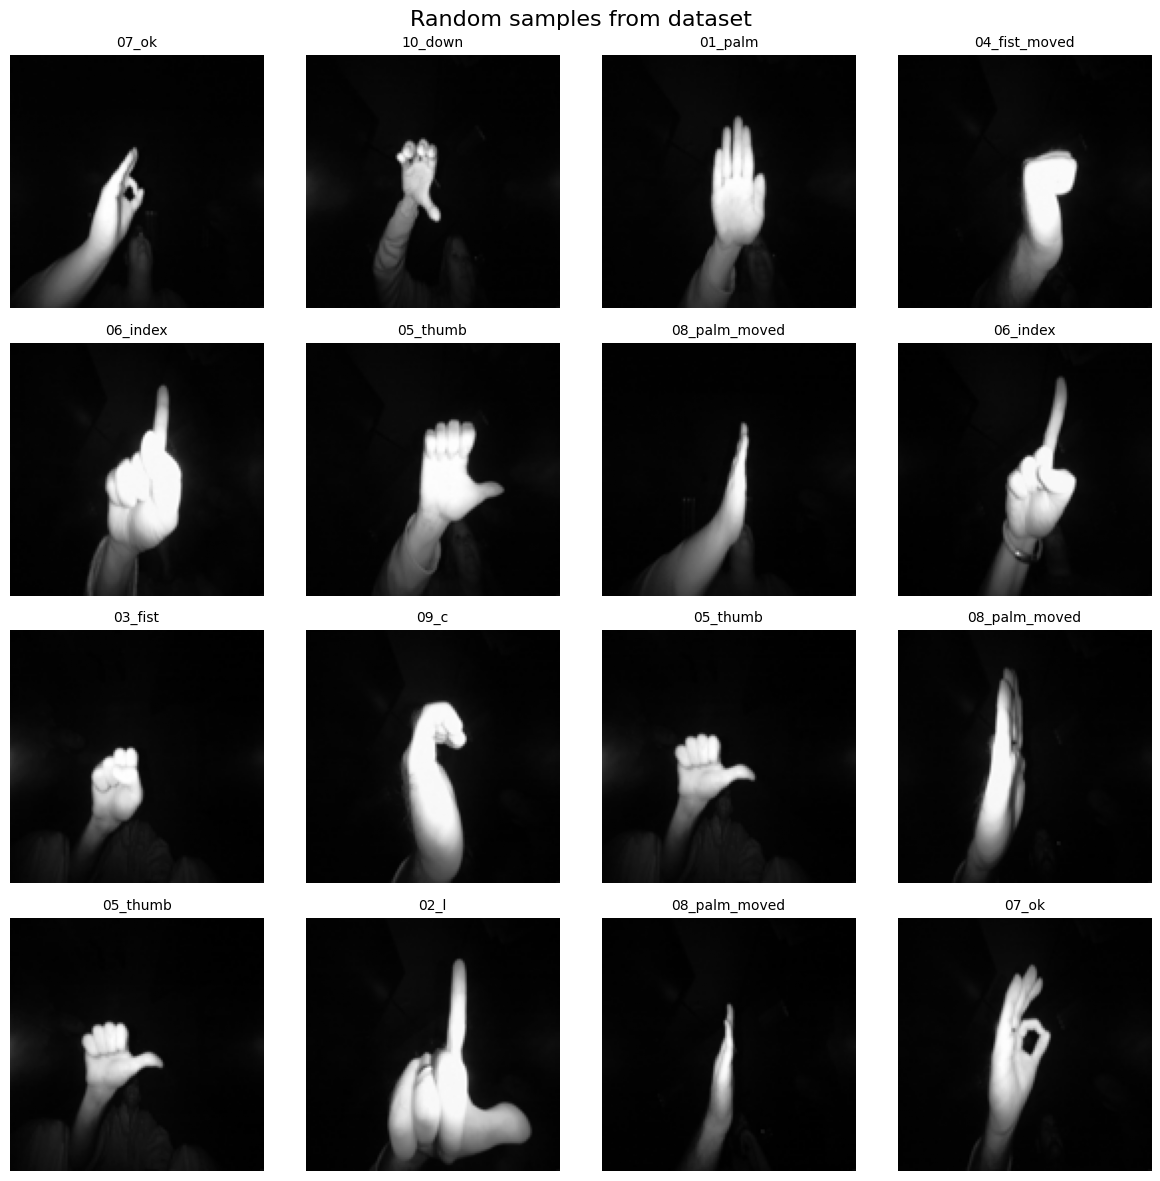

In [ ]:
show_random_samples(x_data, y_labels, n=16)

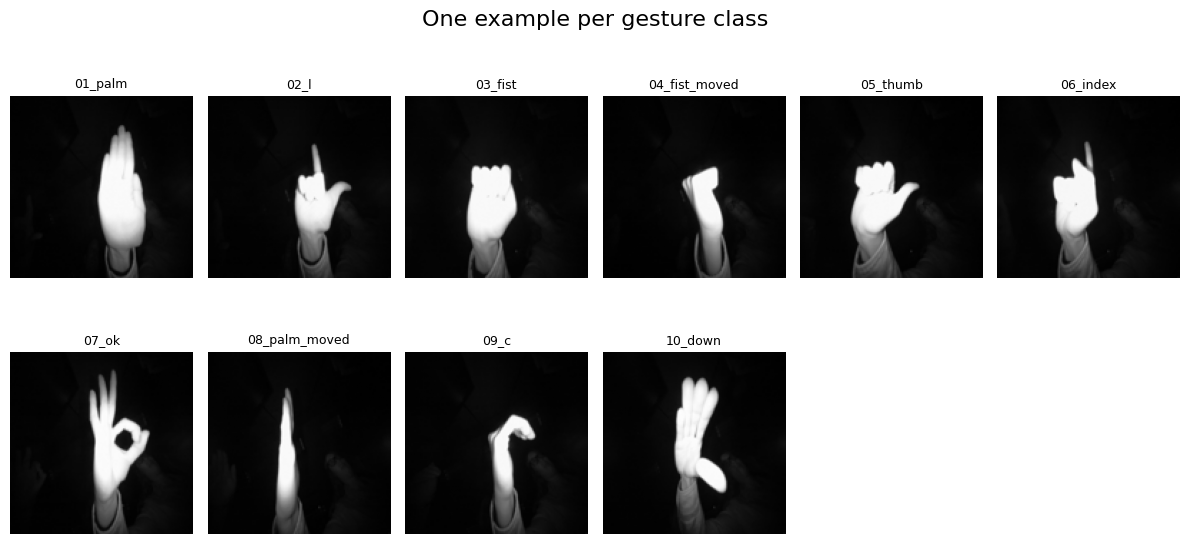

In [ ]:
plt.figure(figsize=(12, 6))
unique_labels = sorted(np.unique(y_labels))
for i, lbl in enumerate(unique_labels):
    idx = np.where(y_labels == lbl)[0][0]
    plt.subplot(2, len(unique_labels)//2 + 1, i + 1)
    plt.imshow(x_data[idx], cmap="gray")
    plt.axis("off")
    plt.title(reverse_lookup[lbl], fontsize=9)
plt.suptitle("One example per gesture class", fontsize=16)
plt.tight_layout()
plt.show()

# **Data Preprocessing**

**Resizing images and normalizing pixel values**

In [ ]:
X = x_data.reshape(-1, IMG_SIZE, IMG_SIZE, 1).astype("float32") / 255.0
y = y_labels
num_classes = len(label_lookup)

print("Input shape:", X.shape)
print("Num classes:", num_classes)

Input shape: (20000, 128, 128, 1)
Num classes: 10


> Since the images are already grayscale, color-based segmentation isn't directly applicable. Also, the dataset images came with minimal background already.


In [ ]:
X_train, X_temp, y_train_int, y_temp_int = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [ ]:
X_val, X_test, y_val_int, y_test_int = train_test_split(
    X_temp, y_temp_int, test_size=0.5, random_state=42, stratify=y_temp_int
)

In [ ]:
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (14000, 128, 128, 1) Val: (3000, 128, 128, 1) Test: (3000, 128, 128, 1)


In [ ]:
y_train = to_categorical(y_train_int, num_classes=num_classes)
y_val   = to_categorical(y_val_int,   num_classes=num_classes)
y_test  = to_categorical(y_test_int,  num_classes=num_classes)

**Data Augmentation**

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.20,
    height_shift_range=0.20,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator()

In [ ]:
train_gen = train_datagen.flow(X_train, y_train, batch_size=64, shuffle=True)
val_gen = val_datagen.flow(X_val, y_val, batch_size=64)

# **Saving The Final Dataset**

In [ ]:
import numpy as np
import pickle

# 1. Save the processed arrays into a compressed format
# We save X_train, X_val, X_test and their corresponding labels
np.savez_compressed('processed_data.npz',
                    X_train=X_train, y_train=y_train,
                    X_val=X_val, y_val=y_val,
                    X_test=X_test, y_test=y_test)

# 2. Save metadata and mappings using Pickle
# This saves the dictionaries used for mapping labels and specific constants
metadata = {
    'label_lookup': label_lookup,
    'reverse_lookup': reverse_lookup,
    'num_classes': num_classes,
    'IMG_SIZE': IMG_SIZE
}

with open('metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print("✅ Data and Metadata saved successfully to 'processed_data.npz' and 'metadata.pkl'")

✅ Data and Metadata saved successfully to 'processed_data.npz' and 'metadata.pkl'
